高知 ダート

# preparation

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold

#エヴァリュエーション
from sklearn.metrics import precision_score, recall_score, mean_squared_error

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#42, 36, 54, 47, 55

In [3]:
#データを読み込む
j_uma_race_df = pd.read_pickle('../datasets/traindata/j_uma_race.pkl')
j_race_df = pd.read_pickle('../datasets/traindata/j_race.pkl')
# j_payout_df = pd.read_pickle('../datasets/traindata/j_payout.pkl')

n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

### データの削除

In [4]:
#浦和競馬場に絞る
pd.set_option('display.max_columns', None)
urayasu_uma_race = n_uma_race_df[n_uma_race_df['keibajo_code'].astype(str) == '54']
urayasu_race = n_race_df[n_race_df['keibajo_code'].astype(str) == '54']
urayasu_uma_race

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei
934,2010,101,54,15,2,1,1,1,2007101895,リワードシャンヴル,0,1,1.0,3,3,3,20173,868005,宮崎 忠比古,540.0,0,5074,赤岡修次,0,452.0,2,2.0,0,1,1,0,0,1305,NaN,NaN,NaN,1,1,1,1,0,0,900,0,0,0,2007102467エイダイジャンプ,0000000000,0000000000,-9,0,0
935,2010,101,54,15,2,1,2,2,2007103725,フラメンコ,0,2,1.0,3,3,3,20471,0,中谷 進一,520.0,0,20490,石本純也,1,396.0,2,1.0,0,6,6,0,0,1335,1.0,NaN,NaN,6,5,5,6,0,0,0,0,0,0,2007101895リワードシャンヴル,0000000000,0000000000,30,0,0
936,2010,101,54,15,2,1,3,3,2007104570,チャローラクシュミ,0,2,1.0,4,3,3,20396,310030,井之口 二三雄,530.0,0,20164,西川敏弘,0,460.0,1,0.0,0,3,3,0,0,1317,112.0,NaN,NaN,7,7,7,2,0,0,110,0,0,0,2007101895リワードシャンヴル,0000000000,0000000000,12,0,0
937,2010,101,54,15,2,1,4,4,2007102570,ナンブエンジェル,0,2,1.0,3,3,3,20471,0,中谷 進一,530.0,0,20447,高野毅,0,400.0,0,10.0,0,4,4,0,0,1333,8.0,NaN,NaN,4,3,3,4,0,0,80,0,0,0,2007101895リワードシャンヴル,0000000000,0000000000,28,0,0
938,2010,101,54,15,2,1,5,5,2007102467,エイダイジャンプ,0,1,1.0,7,3,3,20301,0,安岡 日出男,540.0,0,20389,上田将司,0,439.0,0,3.0,0,2,2,0,0,1314,4.0,NaN,NaN,2,2,2,2,0,0,230,0,0,0,2007101895リワードシャンヴル,0000000000,0000000000,9,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040461,2023,903,54,7,4,11,6,8,2020101750,インペトゥオーソ,0,1,1.0,3,3,3,20647,0,徳田 直樹,560.0,0,21252,林謙佑,0,467.0,2,8.0,0,2,2,0,0,1261,NaN,NaN,NaN,7,7,7,5,82,5,2100,0,0,412,2020101949ナムラダリウス,0000000000,0000000000,0,0,0
2040462,2023,903,54,7,4,11,7,9,2020103021,ヒノタマボーイ,0,1,1.0,4,3,3,20366,0,上岡 和男,560.0,0,5496,郷間勇太,0,474.0,2,5.0,0,12,12,0,0,1294,2.0,NaN,NaN,4,4,5,7,64,3,0,0,0,450,2020101949ナムラダリウス,0000000000,0000000000,33,0,0
2040463,2023,903,54,7,4,11,7,10,2020106520,モズフェアリー,0,2,1.0,1,3,3,20631,159030,村田 裕子,540.0,0,5615,井上瑛太,0,470.0,2,2.0,0,9,9,0,0,1277,212.0,NaN,NaN,9,10,10,10,903,12,0,0,0,416,2020101949ナムラダリウス,0000000000,0000000000,16,0,0
2040464,2023,903,54,7,4,11,8,11,2020104563,スライトマッド,0,2,1.0,4,3,3,20682,368803,ウエスト．フォレスト．ステイブル,540.0,0,5610,岡遼太郎,0,469.0,0,2.0,0,5,5,0,0,1263,12.0,NaN,NaN,1,1,1,1,67,4,600,0,0,423,2020101949ナムラダリウス,0000000000,0000000000,2,0,0


# LightGBM

## グループクエリ用のカラムを作成

In [5]:
# 新しいグループを作成
urayasu_uma_race['group'] = urayasu_uma_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_uma_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_uma_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_uma_race['race_bango'].astype(int).astype(str)
urayasu_race['group'] = urayasu_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_race['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

C:\Users\kawam\AppData\Local\Temp\ipykernel_20532\3114523199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urayasu_uma_race['group'] = urayasu_uma_race['kaisai_nen'].astype(int).astype(str) +"-"+ urayasu_uma_race['kaisai_tsukihi'].astype(int).astype(str) +"-"+  urayasu_uma_race['keibajo_code'].astype(int).astype(str) +"-"+  urayasu_uma_race['race_bango'].astype(int).astype(str)
C:\Users\kawam\AppData\Local\Temp\ipykernel_20532\3114523199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urayasu_race

In [6]:
urayasu_uma_race['group'].unique()

array(['2010-101-54-1', '2010-101-54-2', '2010-101-54-3', ...,
       '2023-903-54-9', '2023-903-54-10', '2023-903-54-11'], dtype=object)

In [7]:
urayasu_race['group'].unique()

array(['2021-101-54-1', '2021-101-54-2', '2021-101-54-3', ...,
       '2020-1231-54-10', '2020-1231-54-11', '2020-1231-54-12'],
      dtype=object)

In [8]:
urayasu_race = urayasu_race.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

In [9]:
merged_df = pd.merge(urayasu_uma_race, urayasu_race, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df, on='group', how='left')
merged_df['group'].nunique()

16324

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160703 entries, 0 to 160702
Data columns (total 82 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   kaisai_nen                  160703 non-null  int64  
 1   kaisai_tsukihi              160703 non-null  int64  
 2   keibajo_code                160703 non-null  object 
 3   kaisai_kai                  160703 non-null  int64  
 4   kaisai_nichime              160703 non-null  int64  
 5   race_bango                  160703 non-null  int64  
 6   wakuban                     160703 non-null  int64  
 7   umaban                      160703 non-null  int64  
 8   ketto_toroku_bango          160703 non-null  int64  
 9   bamei                       160703 non-null  object 
 10  umakigo_code                160703 non-null  int64  
 11  seibetsu_code               160703 non-null  int64  
 12  hinshu_code                 160703 non-null  float64
 13  moshoku_code  

In [11]:
pd.set_option('display.max_columns', None)
merged_df.head(1)

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c
0,2010,101,54,15,2,1,1,1,2007101895,リワードシャンヴル,0,1,1.0,3,3,3,20173,868005,宮崎 忠比古,540.0,0,5074,赤岡修次,0,452.0,2,2.0,0,1,1,0,0,1305,NaN,NaN,NaN,1,1,1,1,0,0,900,0,0,0,2007102467エイダイジャンプ,0000000000,0000000000,-9,0,0,2010-101-54-1,3,0,0,12,0,3,0,0,0,0,0,1300,24,0,9.000000e+50,0,1300,8,8,8,1,0,1.0,0.0,0.0,0.0,10305.0,230.0,NaN


In [12]:
merged_df['kaisai_nen'].value_counts()

kaisai_nen
2017    13465
2019    13125
2018    13042
2020    13022
2016    12899
2015    12882
2021    12674
2022    12008
2014    11777
2013    10803
2012     9423
2011     8615
2023     8557
2010     8411
Name: count, dtype: int64

In [13]:
merged_df['kyori'].value_counts()

kyori
1300    85712
1400    56742
1600    15097
800      2108
1900      716
1800      175
2400      153
Name: count, dtype: int64

In [14]:
merged_df['track_code'].value_counts()
#24	平地　ダート 右回り

track_code
24    160703
Name: count, dtype: int64

In [15]:
merged_df['grade_code'].value_counts()
# 1	G1（平地競走）
# 2	G2（平地競走）
# 3	G3（平地競走）
# 4	グレードのない重賞
# 5	重賞以外の特別競走
# 6	J･G1（障害競走）
# 7	J･G2（障害競走）
# 8	J･G3（障害競走）
# 0	一般競走　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)

grade_code
0    141990
5     18546
3       167
Name: count, dtype: int64

In [16]:
merged_df['umakigo_code'].value_counts()
# 00	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)

umakigo_code
0    160703
Name: count, dtype: int64

In [17]:
merged_df['seibetsu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	牡馬
# 2	牝馬
# 3	セン馬

seibetsu_code
1    85915
2    63331
3    11457
Name: count, dtype: int64

In [18]:
merged_df['hinshu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	サラブレッド	サラ	サラブレッドとして登録したもの。
# 2	サラブレッド系種	サラ系	アラブの血量が２５％未満
# 3	準サラブレッド	準サラ	昭和49年6月1日の登録規定改定により「準サラ」は「サラ系」となり、「準サラ」の品種は廃止された。
# 4	軽半血種	軽半	アングロノルマン、アングロノルマン系種または中半血種と連続2代以上にあたり、軽種を交配したもの。軽半血種相互の交配によって生まれたもの。
# 5	アングロアラブ	アア	アラブの血量が２５％以上（父母の組み合わせにより「アラ系」と異なる。）
# 6	アラブ系種	アラ系	アラブの血量が２５％以上（父母の組み合わせにより「アア」と異なる。）
# 7	アラブ	アラブ	純血のアラブ
# 8	中半血種	中半	異種の中間相互、中半血種の中間相互、の交配で生まれたもの。中半血種と軽種、アングロノルマンとサラブレッドを除く軽種、重半血種と軽種を交配して生まれたもの。

hinshu_code
1.0    160405
2.0       251
5.0        47
Name: count, dtype: int64

In [19]:
merged_df['moshoku_code'].value_counts()
# 00	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 01	栗毛	chestnut	ch.
# 02	栃栗毛	dark chestnut	d.ch.
# 03	鹿毛	bay	b.
# 04	黒鹿毛	dark bay	d.b.
# 05	青鹿毛	brown	br.
# 06	青毛	black	bl.
# 07	芦毛	grey	g.
# 08	栗粕毛		
# 09	鹿粕毛		
# 10	青粕毛		
# 11	白毛	white	w.

moshoku_code
3     68364
1     40145
4     31554
5     10627
7      7839
6      1660
2       508
11        6
Name: count, dtype: int64

In [20]:
merged_df['barei'].value_counts()

barei
4     37262
5     28404
3     25478
6     22122
7     16053
8     12451
9      8233
10     4298
2      2949
11     2003
12      855
13      324
14      197
15       74
Name: count, dtype: int64

In [21]:
merged_df['kishu_code'].value_counts()

kishu_code
5536     9300
20389    9073
20164    8874
5074     8650
20521    8568
         ... 
1102        1
21327       1
5602        1
21324       1
5633        1
Name: count, Length: 346, dtype: int64

In [22]:
merged_df['chokyoshi_code'].value_counts()

chokyoshi_code
5663     13567
20173    13411
20305    11181
5580     11137
20366     9944
         ...  
20511        1
20418        1
1046         1
5212         1
1003         1
Name: count, Length: 212, dtype: int64

In [23]:
merged_df['banushi_code'].value_counts()

banushi_code
0         86153
489033     7651
677009     6529
815800     3189
92803      3113
          ...  
748008        1
648033        1
506800        1
611006        1
552031        1
Name: count, Length: 546, dtype: int64

In [24]:
merged_df['kishu_minarai_code'].value_counts()
# 0	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	☆	1Kg減	通算免許期間が3年未満の騎手で勝利数が51回以上100回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が31回以上100回以下(2003年まで)
# 2	△	2Kg減	通算免許期間が3年未満の騎手で勝利数が31回以上50回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が21回以上30回以下(2003年まで)
# 3	▲	3Kg減	通算免許期間が3年未満の騎手で勝利数が30回以下(2004年から) 通算免許期間が3年未満の騎手で勝利数が20回以下(2003年まで)

kishu_minarai_code
0    132069
1     15740
3      7296
2      4154
4      1444
Name: count, dtype: int64

In [25]:
merged_df['futan_juryo'].value_counts()

futan_juryo
560.0    76172
540.0    48602
530.0    13679
550.0    13157
510.0     3418
520.0     3249
570.0     1487
500.0      883
580.0       32
490.0       15
590.0        9
Name: count, dtype: int64

In [26]:
merged_df['bataiju'].value_counts()

bataiju
454.0    1904
458.0    1892
461.0    1877
456.0    1877
464.0    1872
         ... 
601.0       1
587.0       1
584.0       1
328.0       1
342.0       1
Name: count, Length: 251, dtype: int64

In [27]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']

In [28]:
merged_df['zogen_fugo'].value_counts()

zogen_fugo
0    71326
2    70368
1    19009
Name: count, dtype: int64

In [29]:
merged_df['zogen_sa'].value_counts()

zogen_sa
1.0      29253
2.0      26563
3.0      22596
4.0      17716
0.0      15348
5.0      13432
6.0       9945
7.0       6860
8.0       4740
9.0       3121
10.0      2109
999.0     1504
11.0      1388
12.0       969
13.0       637
14.0       535
15.0       366
16.0       258
17.0       223
18.0       179
19.0       118
20.0       115
22.0        85
21.0        81
24.0        50
23.0        47
26.0        42
25.0        39
27.0        34
31.0        26
28.0        26
30.0        23
32.0        16
33.0        16
29.0        15
38.0        10
35.0         9
39.0         9
34.0         9
36.0         6
40.0         5
47.0         4
37.0         4
49.0         3
50.0         3
43.0         2
46.0         1
58.0         1
52.0         1
42.0         1
41.0         1
45.0         1
60.0         1
Name: count, dtype: int64

In [30]:
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)

# scaler = MinMaxScaler()
# merged_df['zogen_ryou'] = scaler.fit_transform(merged_df[['zogen_ryou']])

In [31]:
merged_df['ijo_kubun_code'].value_counts()
# 0	下記以外　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	出走取消	取消	SCRATCHED	S
# 2	発走除外	発除	EXCLUDED BY STARTERS	ES
# 3	競走除外	競除	EXCLUDED BY STEWARDS	ER
# 4	競走中止	中止	FALL TO FINISH	FF
# 5	失格	失格	DISQUALIFIED	DQ
# 6	落馬再騎乗	再騎	REMOUNT AFTER A CROPPER	RM
# 7	降着	降着	DISQUALIFIED AND PLACED	DQ&P

ijo_kubun_code
0    158362
1      1695
3       344
4       294
5         5
7         3
Name: count, dtype: int64

In [32]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]

In [33]:
merged_df['kyoso_shubetsu_code'].value_counts()
# 00	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 11	サラブレッド系2歳	サラ２才	サラ系２歳	サラ系２歳	TWO-YEAR-OLDS
# 12	サラブレッド系3歳	サラ３才	サラ系３歳	サラ系３歳	THREE-YEAR-OLDS
# 13	サラブレッド系3歳以上	サラ３上	サラ系３歳上	サラ系３歳以上	THREE-YEAR-OLDS & UP
# 14	サラブレッド系4歳以上	サラ４上	サラ系４歳上	サラ系４歳以上	FOUR-YEAR-OLDS & UP
# 18	サラブレッド系障害3歳以上	障害３上	障害３歳上	サラ障害３歳以上	THREE-YEAR-OLDS & UP STEEPLE-CHASE
# 19	サラブレッド系障害4歳以上	障害４上	障害４歳上	サラ障害４歳以上	FOUR-YEAR-OLDS & UP STEEPLE-CHASE
# 21	アラブ系2歳	アラ２才	アラ系２歳	アラブ系２歳	TWO-YEAR-OLDS ANGLO-ARABS
# 22	アラブ系3歳	アラ３才	アラ系３歳	アラブ系３歳	THREE-YEAR-OLDS ANGLO-ARABS
# 23	アラブ系3歳以上	アラ３上	アラ系３歳上	アラブ系３歳以上	THREE-YEAR-OLDS & UP ANGLO-ARABS
# 24	アラブ系4歳以上	アラ４上	アラ系４歳上	アラブ系４歳以上	FOUR-YEAR-OLDS & UP ANGLO-ARABS

kyoso_shubetsu_code
49    141231
12     11078
11      2618
14      1940
13      1463
47        21
43        11
Name: count, dtype: int64

In [34]:
j_race_df['kyoso_shubetsu_code'].value_counts()

kyoso_shubetsu_code
12    21794
0     19750
13    18724
14    13839
11    11907
18     1007
19      760
Name: count, dtype: int64

In [35]:
merged_df['kyoso_kigo_code'].value_counts()
# 000	記号なし　または未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 001	(指定)	DSN
# 002	見習騎手 (2003年までの表記)若手騎手 (2004年からの表記)	
# 003	[指定]	DES
# 004	(特指)	SD

kyoso_kigo_code
0    158362
Name: count, dtype: int64

In [36]:
merged_df['juryo_shubetsu_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	ハンデ	HANDICAP	出走馬の実績等を考慮し、ハンデキャッパーが負担重量を決定するレース
# 2	別定	SPECIAL WEIGHT	レースごとに負担重量を決定する基準が設けられているレース
# 3	馬齢	WEIGHT FOR AGE	馬の年齢や性別によって負担重量を決定するレース
# 4	定量	SPECIAL WEIGHT	別定レースであって、馬の年齢や性別によって負担重量を決定するレース

juryo_shubetsu_code
9    140407
3     14117
2      2187
4      1511
0       140
Name: count, dtype: int64

In [37]:
merged_df['kyoso_joken_code'].value_counts()
# 000	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 001	１００万円以下	1,000,000 & LESS	収得賞金が100万円以下の馬が出走できる。
# 002	２００万円以下	2,000,000 & LESS	収得賞金が200万円以下の馬が出走できる。
# 003	３００万円以下	3,000,000 & LESS	収得賞金が300万円以下の馬が出走できる。
# 099	９９００万円以下	99,000,000 & LESS	収得賞金が9900万円以下の馬が出走できる。
# 100	１億円以下	100,000,000 & LESS	収得賞金が1億円以下の馬が出走できる。
# 701	新馬	NEWCOMER	サラブレッド系の未出走馬が出走できる。
# 702	未出走	UNRACED	当該競馬以外の競馬(地方競馬または外国の競馬を含む)において、出走したことがなく、当該競馬において、第1着または重賞競走の第2着になったことのない馬が出走できる。
# 703	未勝利	MAIDEN	該当競馬以外の競馬(地方競馬または外国の競馬を含む)において出走し、収得賞金がない馬が出走できる。また未出走馬も出走できる。
# 999	オープン	OPEN	特に記載のない限り、すべての馬が出走できる競走

kyoso_joken_code
0    158362
Name: count, dtype: int64

In [38]:
merged_df['course_kubun'].value_counts()
# 半角2文字　使用するコースを設定
# "A " ～ "E " を設定 尚、2002年以前の東京競馬場は"A1"、"A2"も存在

course_kubun
0    158362
Name: count, dtype: int64

In [39]:
merged_df['shusso_tosu'].value_counts()

shusso_tosu
12    34386
10    34211
11    32323
9     25462
8     19788
7      7498
6      2320
0      1642
5       708
4        24
Name: count, dtype: int64

In [40]:
merged_df['tenko_code'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	晴	Fine
# 2	曇	Cloudy
# 3	雨	Rainy
# 4	小雨	Drizzle
# 5	雪	Snow
# 6	小雪	Light Snow

tenko_code
1    96624
2    42030
3    16233
4     2474
0      676
6      211
5      114
Name: count, dtype: int64

In [41]:
merged_df['babajotai_code_shiba'].value_counts()

babajotai_code_shiba
0    158362
Name: count, dtype: int64

In [42]:
merged_df['babajotai_code_dirt'].value_counts()
# 0	未設定・未整備時の初期値(主に地方競馬・海外国際レースに関するデータ)
# 1	良	Firm	Standard
# 2	稍重	Good	Good
# 3	重	Yielding	Muddy
# 4	不良	Soft	Sloppy

babajotai_code_dirt
3.0    57369
4.0    54663
1.0    23079
2.0    22575
0.0      676
Name: count, dtype: int64

In [43]:
merged_df['haraimodoshi_sanrenpuku_1b'].value_counts()

haraimodoshi_sanrenpuku_1b
360.0      1148
230.0      1147
280.0      1130
180.0      1079
210.0      1060
           ... 
24380.0       7
8390.0        7
10480.0       7
48620.0       7
30940.0       7
Name: count, Length: 2375, dtype: int64

## LightGBM

### テスト用と学習用のデータに分け、モデルを作成

In [44]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'kyori',
            'grade_code',
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'shusso_tosu',
            'tenko_code',
            'babajotai_code_dirt',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'kakutei_chakujun'

# LightGBM用のデータセットを作成
train_dataset = lgb.Dataset(train_data[features], label=train_data[target])

def objective(trial):
    # Optunaで調整するパラメータを設定
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
    }
    
    # k=5のFOLDでデータを分割
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # 各FOLDでの評価値を保存するためのリスト
    rmses = []
    
    # LightGBMモデルを訓練
    for train_index, valid_index in kf.split(train_data):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
        
        train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
        valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
        
        model = lgb.train(params, train_dataset, num_boost_round=1000, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=100)
        
        # RMSEを計算して保存
        y_pred = model.predict(valid_fold_data[features])
        rmse = np.sqrt(mean_squared_error(valid_fold_data[target], y_pred))
        rmses.append(rmse)
    
    # 5-FOLDの平均RMSEを返す
    return np.mean(rmses)

# Optunaでのパラメータ探索を実行
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# 最適なパラメータ
best_params = study.best_params
best_params['metric'] = 'rmse'  # ここでmetricを追加

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_dataset = lgb.Dataset(train_fold_data[features], label=train_fold_data[target])
    valid_dataset = lgb.Dataset(valid_fold_data[features], label=valid_fold_data[target])
    
    model = lgb.train(best_params, train_dataset, num_boost_round=500, valid_sets=[valid_dataset], early_stopping_rounds=20, verbose_eval=100)  # ここでearly_stopping_roundsを50に変更
    models.append(model)

[I 2023-10-08 14:20:30,598] A new study created in memory with name: no-name-9568e110-9e71-4e41-82bd-522b74e26bf1


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.853
[200]	valid_0's rmse: 2.74876
[300]	valid_0's rmse: 2.68827
[400]	valid_0's rmse: 2.65176
[500]	valid_0's rmse: 2.63013
[600]	valid_0's rmse: 2.61578
[700]	valid_0's rmse: 2.60526
[800]	valid_0's rmse: 2.59686
[900]	valid_0's rmse: 2.59081
[1000]	valid_0's rmse: 2.58621
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.58621
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col

[I 2023-10-08 14:21:52,171] Trial 0 finished with value: 2.573952873658869 and parameters: {'num_leaves': 255, 'learning_rate': 0.004614567437464401, 'feature_fraction': 0.5810861658505667}. Best is trial 0 with value: 2.573952873658869.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.68364
[200]	valid_0's rmse: 2.6452
[300]	valid_0's rmse: 2.62675
[400]	valid_0's rmse: 2.6181
[500]	valid_0's rmse: 2.6107
[600]	valid_0's rmse: 2.60582
[700]	valid_0's rmse: 2.60114
[800]	valid_0's rmse: 2.5975
[900]	valid_0's rmse: 2.59394
[1000]	valid_0's rmse: 2.59087
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.59087
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003234 seconds.
You can set `force_row_wise=true` to remove the

[I 2023-10-08 14:22:10,411] Trial 1 finished with value: 2.577976250699694 and parameters: {'num_leaves': 31, 'learning_rate': 0.023404675476625933, 'feature_fraction': 0.7309150902558386}. Best is trial 0 with value: 2.573952873658869.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.92787
[200]	valid_0's rmse: 2.85081
[300]	valid_0's rmse: 2.79396
[400]	valid_0's rmse: 2.75118
[500]	valid_0's rmse: 2.71879
[600]	valid_0's rmse: 2.69611
[700]	valid_0's rmse: 2.67846
[800]	valid_0's rmse: 2.66522
[900]	valid_0's rmse: 2.65444
[1000]	valid_0's rmse: 2.64596
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.64596
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_row_wise=true` to remove

[I 2023-10-08 14:22:48,857] Trial 2 finished with value: 2.6368262081051332 and parameters: {'num_leaves': 95, 'learning_rate': 0.002740831374904439, 'feature_fraction': 0.4866811795553747}. Best is trial 0 with value: 2.573952873658869.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.60198
[200]	valid_0's rmse: 2.56898
[300]	valid_0's rmse: 2.56068
[400]	valid_0's rmse: 2.55574
[500]	valid_0's rmse: 2.55269
[600]	valid_0's rmse: 2.55235
Early stopping, best iteration is:
[582]	valid_0's rmse: 2.55196
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Numbe

[I 2023-10-08 14:23:20,484] Trial 3 finished with value: 2.5398967793381018 and parameters: {'num_leaves': 238, 'learning_rate': 0.03975358321436955, 'feature_fraction': 0.9062926766696882}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.71143
[200]	valid_0's rmse: 2.66309
[300]	valid_0's rmse: 2.64053
[400]	valid_0's rmse: 2.62605
[500]	valid_0's rmse: 2.6179
[600]	valid_0's rmse: 2.6121
[700]	valid_0's rmse: 2.60722
[800]	valid_0's rmse: 2.60311
[900]	valid_0's rmse: 2.59977
[1000]	valid_0's rmse: 2.59705
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.59705
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002618 seconds.
You can set `force_row_wise=true` to remove t

[I 2023-10-08 14:23:38,802] Trial 4 finished with value: 2.5840228883536893 and parameters: {'num_leaves': 40, 'learning_rate': 0.015327700806154547, 'feature_fraction': 0.8679666875175795}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.98484
[200]	valid_0's rmse: 2.94011
[300]	valid_0's rmse: 2.90134
[400]	valid_0's rmse: 2.86745
[500]	valid_0's rmse: 2.83831
[600]	valid_0's rmse: 2.81309
[700]	valid_0's rmse: 2.79053
[800]	valid_0's rmse: 2.77109
[900]	valid_0's rmse: 2.75419
[1000]	valid_0's rmse: 2.7397
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.7397
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004215 seconds.
You can set `force_row_wise=true` to remove t

[I 2023-10-08 14:24:50,992] Trial 5 finished with value: 2.7374955399334975 and parameters: {'num_leaves': 223, 'learning_rate': 0.000852453334379943, 'feature_fraction': 0.9335325778928344}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.03018
[200]	valid_0's rmse: 3.02363
[300]	valid_0's rmse: 3.0171
[400]	valid_0's rmse: 3.01057
[500]	valid_0's rmse: 3.00391
[600]	valid_0's rmse: 2.99769
[700]	valid_0's rmse: 2.99147
[800]	valid_0's rmse: 2.98555
[900]	valid_0's rmse: 2.97943
[1000]	valid_0's rmse: 2.97365
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.97365
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002476 seconds.
You can set `force_row_wise=true` to remove 

[I 2023-10-08 14:25:52,995] Trial 6 finished with value: 2.9759383007839038 and parameters: {'num_leaves': 206, 'learning_rate': 0.00014057284472887118, 'feature_fraction': 0.5224486957288845}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.0187
[200]	valid_0's rmse: 3.00155
[300]	valid_0's rmse: 2.98537
[400]	valid_0's rmse: 2.96994
[500]	valid_0's rmse: 2.9552
[600]	valid_0's rmse: 2.94153
[700]	valid_0's rmse: 2.92856
[800]	valid_0's rmse: 2.9163
[900]	valid_0's rmse: 2.90467
[1000]	valid_0's rmse: 2.89377
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.89377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002480 seconds.
You can set `force_row_wise=true` to remove th

[I 2023-10-08 14:26:08,825] Trial 7 finished with value: 2.8950110870180543 and parameters: {'num_leaves': 29, 'learning_rate': 0.00034359274961305196, 'feature_fraction': 0.8602324977914924}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 3.0186
[200]	valid_0's rmse: 3.00077
[300]	valid_0's rmse: 2.98413
[400]	valid_0's rmse: 2.96811
[500]	valid_0's rmse: 2.95236
[600]	valid_0's rmse: 2.93749
[700]	valid_0's rmse: 2.92348
[800]	valid_0's rmse: 2.9107
[900]	valid_0's rmse: 2.89797
[1000]	valid_0's rmse: 2.88628
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.88628
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove t

[I 2023-10-08 14:26:39,499] Trial 8 finished with value: 2.8866693555516054 and parameters: {'num_leaves': 82, 'learning_rate': 0.0003683006546905178, 'feature_fraction': 0.631988509722077}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 2.70842
[200]	valid_0's rmse: 2.67167
[300]	valid_0's rmse: 2.65356
[400]	valid_0's rmse: 2.64479
[500]	valid_0's rmse: 2.63808
[600]	valid_0's rmse: 2.63251
[700]	valid_0's rmse: 2.62773
[800]	valid_0's rmse: 2.62407
[900]	valid_0's rmse: 2.62071
[1000]	valid_0's rmse: 2.61788
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 2.61788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove

[I 2023-10-08 14:26:51,391] Trial 9 finished with value: 2.6061914906626162 and parameters: {'num_leaves': 11, 'learning_rate': 0.029582131961577655, 'feature_fraction': 0.5085609163295799}. Best is trial 3 with value: 2.5398967793381018.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 90288, number of used features: 16
[LightGBM] [Info] Start training from score 5.390628
Training until validation scores don't improve for 20 rounds
[100]	valid_0's rmse: 2.60198
[200]	valid_0's rmse: 2.56898
[300]	valid_0's rmse: 2.56068
[400]	valid_0's rmse: 2.55574
[500]	valid_0's rmse: 2.55269
Did not meet early stopping. Best iteration is:
[497]	valid_0's rmse: 2.55256
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points i

### テストデータで予測

In [45]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
127686,2021-101-54-1,6.0,4
127687,2021-101-54-1,2.0,3
127688,2021-101-54-1,11.0,10
127689,2021-101-54-1,8.0,5
127690,2021-101-54-1,3.0,1
...,...,...,...
140355,2021-1231-54-11,8.0,3
140356,2021-1231-54-11,3.0,1
140357,2021-1231-54-11,9.0,2
140358,2021-1231-54-11,6.0,11


## モデル評価

In [46]:
# RMSEを計算
rmse_2020 = np.sqrt(mean_squared_error(test_data_2020['predicted_rank'], test_data_2020['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2020:.3%}")
rmse_2021 = np.sqrt(mean_squared_error(test_data_2021['predicted_rank'], test_data_2021['kakutei_chakujun']))
print(f"2021 RMSE: {rmse_2021:.3%}")
rmse_2022 = np.sqrt(mean_squared_error(test_data_2022['predicted_rank'], test_data_2022['kakutei_chakujun']))
print(f"2022 RMSE: {rmse_2022:.3%}")
rmse_mean = np.mean([rmse_2020, rmse_2021, rmse_2022])
print(f"Mean RMSE: {rmse_mean:.3%}")

2021 RMSE: 343.496%
2021 RMSE: 355.604%
2022 RMSE: 367.243%
Mean RMSE: 355.448%


In [47]:
group_ids_2020 = test_data_2020['group'].unique()
precisions = []
recalls = []

In [48]:
def precision_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    precision = len(common_elements) / 5
    return precision

def recall_at_5(predictions, actual):
    top_5_predictions = predictions.argsort()[-5:][::-1]  # 予測の上位5頭のインデックス
    top_3_actual = actual.argsort()[-3:][::-1]  # 実際の上位3頭のインデックス
    common_elements = np.intersect1d(top_5_predictions, top_3_actual)  # 共通の要素を抽出
    recall = len(common_elements) / 3
    return recall

In [49]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'y_pred').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

In [50]:
for test_data in [test_data_2020, test_data_2021, test_data_2022]:
    merged_data = test_data
    profits = merged_data.groupby('group').apply(calculate_group_profit).reset_index()
    profits.columns = ['group', 'profit']
    test_data = pd.merge(test_data, profits, on='group', how='left')

for group_id in group_ids_2020:
    test_data = test_data_2020[test_data_2020['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2020 = np.mean(precisions)
recall_5_2020 = np.mean(recalls)

print(f"2020 Precision@5: {precision_5_2020:.3%}")
print(f"2020 Recall@5: {recall_5_2020:.3%}")

group_ids_2021 = test_data_2021['group'].unique()
precisions = []
recalls = []

2020 Precision@5: 40.737%
2020 Recall@5: 67.894%


In [51]:
for group_id in group_ids_2021:
    test_data = test_data_2021[test_data_2021['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2021 = np.mean(precisions)
recall_5_2021 = np.mean(recalls)

print(f"2021 Precision@5: {precision_5_2021:.3%}")
print(f"2021 Recall@5: {recall_5_2021:.3%}")


roup_ids_2022 = test_data_2022['group'].unique()
precisions = []
recalls = []

for group_id in roup_ids_2022:
    test_data = test_data_2022[test_data_2022['group'] == group_id]
    p = precision_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    r = recall_at_5(test_data['predicted_rank'].values, test_data['kakutei_chakujun'].values)
    precisions.append(p)
    recalls.append(r)

precision_5_2022 = np.mean(precisions)
recall_5_2022 = np.mean(recalls)

print(f"2022 Precision@5: {precision_5_2022:.3%}")
print(f"2022 Recall@5: {recall_5_2022:.3%}")


precision_5_mean = np.mean([precision_5_2020, precision_5_2021, precision_5_2022])
recall_5_mean = np.mean([recall_5_2020, recall_5_2021, recall_5_2022])

print(f"Mean Precision@5: {precision_5_mean:.3%}")
print(f"Mean Recall@5: {recall_5_mean:.3%}")

# 各レースで上記の関数を適用
results_2020 = test_data_2020.groupby('group').apply(check_top3_in_top5_predictions)
results_2021 = test_data_2021.groupby('group').apply(check_top3_in_top5_predictions)
results_2022 = test_data_2022.groupby('group').apply(check_top3_in_top5_predictions)

# 予測モデルが成功したレースのインデックスを取得する
successful_groups_2020 = results_2020[results_2020].index
successful_groups_2021 = results_2021[results_2021].index
successful_groups_2022 = results_2022[results_2022].index

# そのインデックスを使用して、harai_dfから対応する支払倍率を取得する
successful_payout_2020 = merged_df[merged_df['group'].isin(successful_groups_2020)]
successful_payout_2021 = merged_df[merged_df['group'].isin(successful_groups_2021)]
successful_payout_2022 = merged_df[merged_df['group'].isin(successful_groups_2022)]

payouts_2020 = successful_payout_2020['haraimodoshi_sanrenpuku_1b']
payouts_2021 = successful_payout_2021['haraimodoshi_sanrenpuku_1b']
payouts_2022 = successful_payout_2022['haraimodoshi_sanrenpuku_1b']

# すべての成功したレースに対して、100円をかけた場合の支払いを計算する
total_payout_2020 = (payouts_2020).sum()
total_payout_2021 = (payouts_2021).sum()
total_payout_2022 = (payouts_2022).sum()

# 合計の支払いから、すべてのレースにかけた合計金額を引くことで、純利益を計算する
total_investment_2020 = test_data_2020['group'].nunique() * 1000
total_investment_2021 = test_data_2021['group'].nunique() * 1000
total_investment_2022 = test_data_2021['group'].nunique() * 1000

net_profit_2020 = total_payout_2020 - total_investment_2020
net_profit_2021 = total_payout_2021 - total_investment_2021
net_profit_2022 = total_payout_2022 - total_investment_2022

average_net_profit_2020 = net_profit_2020/len(test_data_2020)
average_net_profit_2021 = net_profit_2021/len(test_data_2021)
average_net_profit_2022 = net_profit_2020/len(test_data_2022)

print(f"2020 Average Net Profit: {average_net_profit_2020:.3f} yen")
print(f"2021 Average Net Profit: {average_net_profit_2021:.3f} yen")
print(f"2022 Average Net Profit: {average_net_profit_2022:.3f} yen")

mean_average_net_profit = np.mean([average_net_profit_2020, average_net_profit_2021, average_net_profit_2022])
print(f"Mean Average Net Profit: {mean_average_net_profit:.3f} yen")

2021 Precision@5: 39.222%
2021 Recall@5: 65.370%
2022 Precision@5: 38.230%
2022 Recall@5: 63.717%
Mean Precision@5: 39.396%
Mean Recall@5: 65.661%
2020 Average Net Profit: 772.317 yen
2021 Average Net Profit: 431.062 yen
2022 Average Net Profit: 840.033 yen
Mean Average Net Profit: 681.137 yen


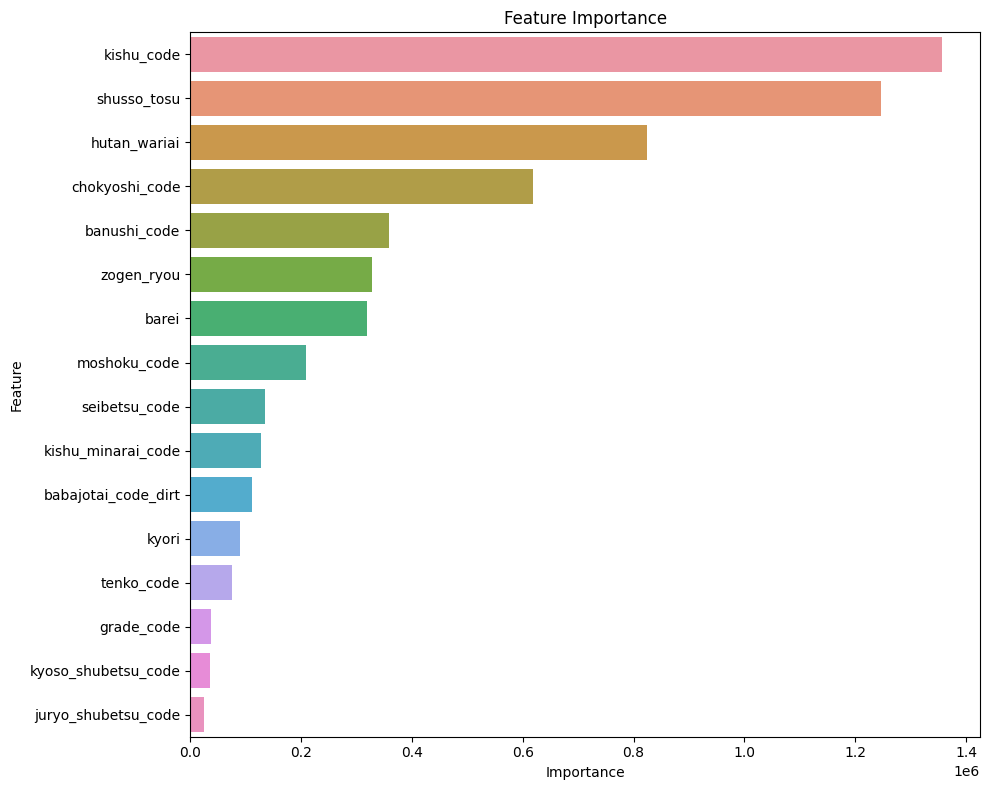

In [52]:
# models[0]の特徴量の重要度を取得
feature_importance = models[0].feature_importance(importance_type='gain')

# 特徴量の名前と重要度をDataFrameに変換
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# 重要度の降順にソート
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# プロット
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [53]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. 箱ひげ図
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x='kyakushitsu_hantei', y=feature, data=test_data_2020)
#     plt.title(f'Box plot of {feature} by label')
#     plt.show()

# # 2. バイオリンプロット
# for feature in features:
#     plt.figure(figsize=(10, 6))
#     sns.violinplot(x='kyakushitsu_hantei', y=feature, data=test_data_2020)
#     plt.title(f'Violin plot of {feature} by label')
#     plt.show()

# # 3. ペアプロット (特徴量が多すぎる場合は時間がかかる可能性があるので注意)
# sns.pairplot(test_data_2020, hue='kyakushitsu_hantei', vars=features)
# plt.show()

# モデル保存

In [54]:
# 学習
full_train_dataset = lgb.Dataset(merged_df[features], label=merged_df[target])
full_model = lgb.train(best_params, full_train_dataset, num_boost_round=500, verbose_eval=100)  # ここではvalid_setsやearly_stopping_roundsは使用しない

# モデルを保存
model_save_path = 'bestmodels/kouchi.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(full_model, f)

print(f"Model saved to {model_save_path}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 158362, number of used features: 16
[LightGBM] [Info] Start training from score 5.435224
Model saved to bestmodels/kouchi.pkl
